In [18]:
import pickle

import gpjax as gpx
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from inference import calculate_predictive_dist
from kernelsearch import set_trainables
from util import calculate_example_lightcurve, lc_model

rng_key = jax.random.PRNGKey(42)

plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

## LC POSTERIOR

In [20]:
models = [
    np.load(
        f"saved/{model}_parameter.npy",
    )
    for model in ["gpmodel", "gpmodel_periodic", "gpmodel_rbf"]
]
ground_truth = [0.1, 0.1, 0.3]

In [21]:
dfs = []
names = ["Learned", "RBF", "Periodic"]
for model, name in zip(models, names):
    df = pd.DataFrame(np.exp(model), columns=["radius ratio", "$u_1$", "$u_2$"])
    df["Kernel"] = name
    dfs.append(df)
df = pd.concat(dfs)

In [22]:
df[df["Kernel"] == "RBF"].describe()

,radius ratio,$u_1$,$u_2$
count,4000.000000,4000.000000,4000.000000
mean,0.104725,0.179019,0.281466
std,0.007083,0.144311,0.213834
min,0.078099,0.000164,0.000053
25%,0.100216,0.065743,0.106398
50%,0.105055,0.144262,0.230745
75%,0.109550,0.255619,0.415050
max,0.125619,0.907106,0.997288


/home/chris/mambaforge/envs/hobby/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


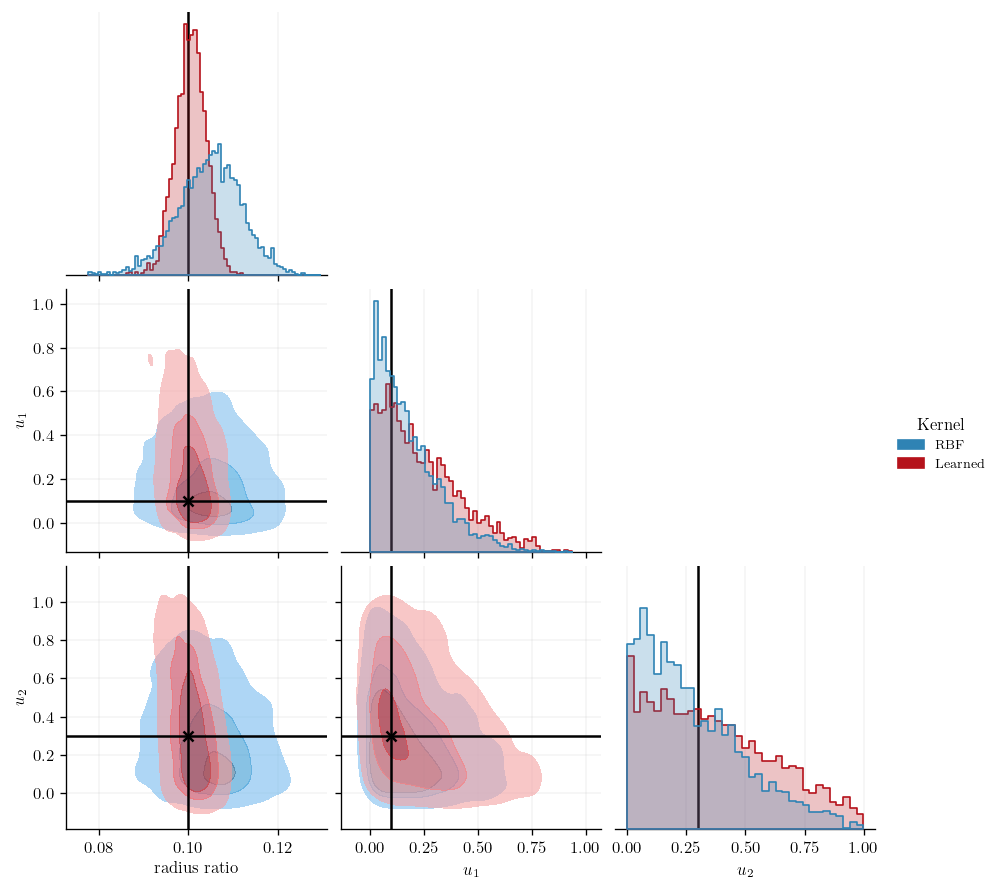

In [23]:
plot = sns.pairplot(
    df,
    corner=True,
    hue="Kernel",
    hue_order=["RBF", "Learned"],
    diag_kind="hist",
    kind="kde",
    diag_kws={"element": "step"},
    plot_kws={"fill": True, "alpha": 0.6, "levels": 4},
)

# Iterate over the axes
for i in range(3):
    for j in range(3):
        if plot.axes[i, j]:
            plot.axes[i, j].axvline(ground_truth[j], color="k")
            if i != j:
                plot.axes[i, j].scatter(ground_truth[j], ground_truth[i], color="k")
                plot.axes[i, j].axhline(ground_truth[i], color="k")

plt.savefig("figures/corner_simple.pdf")
plt.show()

## AR NOISE

In [7]:
white_noise_std = 0.001
phi = 0.8
(
    t_train,
    lc_train,
    train_mask,
    t,
    lightcurve,
    systematics,
    noise,
    mask,
) = calculate_example_lightcurve(noise_std=white_noise_std, phi=phi)

noise_std = white_noise_std / np.sqrt(1 - phi**2)

In [8]:
lc_parameter = np.load("saved/gpmodel_ar_parameter.npy")
gp_parameter = np.load("saved/gpmodel_ar_parameter_gp.npy")
with open("saved/gpmodel_ar", "rb") as file:
    gpmodel = pickle.load(file)

In [9]:
df = pd.DataFrame(np.exp(lc_parameter), columns=["radius ratio", "$u_1$", "$u_2$"])
df.describe()

,radius ratio,$u_1$,$u_2$
count,4000.000000,4000.000000,4000.000000
mean,0.105586,0.295980,0.347775
std,0.003624,0.202266,0.253006
min,0.093168,0.000366,0.000374
25%,0.103123,0.133809,0.134157
50%,0.105689,0.267023,0.293132
75%,0.108050,0.425835,0.519843
max,0.117212,0.978675,0.999992


### Model Fit

In [10]:
def calc_model(t, lc_par, gp_par, key, return_cov=False):
    lc_m = lc_model(t, lc_par)
    gp = set_trainables(gpmodel, gp_par, unconstrain=True).constrain()
    pred_dist = calculate_predictive_dist(
        gp,
        t.reshape(-1, 1),
        gpx.Dataset(
            X=t_train[train_mask].reshape(-1, 1), y=lc_train[train_mask].reshape(-1, 1)
        ),
    )
    gp_m = pred_dist.sample(seed=key)
    if return_cov:
        cov = pred_dist.covariance()
        return (lc_m + gp_m), cov
    return lc_m + gp_m

In [11]:
sample_idx = np.random.choice(len(gp_parameter), 1000)
samples = []

for idx in sample_idx:
    rng_key, sample_key = jax.random.split(rng_key, 2)
    samples.append(calc_model(t, lc_parameter[idx], gp_parameter[idx], sample_key))

samples = np.array(samples)

sample_percentiles = np.nanpercentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)

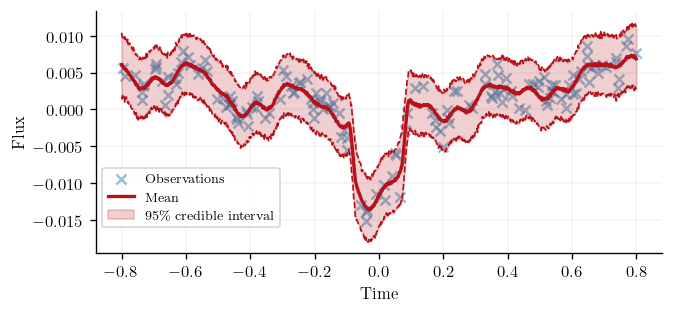

In [12]:
fig, ax = plt.subplots()
ax.scatter(t_train, lc_train, label="Observations", color=cols[0], alpha=0.5)
ax.plot(
    t,
    sample_percentiles[2],
    label="Mean",
    color=cols[1],
    linestyle="-",
    linewidth=2,
)

ax.fill_between(
    t,
    sample_percentiles[0],
    sample_percentiles[-1],
    alpha=0.2,
    label=r"95\% credible interval",
    color=cols[1],
)
ax.plot(
    t,
    sample_percentiles[0],
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    sample_percentiles[-1],
    linestyle="--",
    linewidth=1,
    color=cols[1],
)


ax.legend(loc="center left", bbox_to_anchor=(0, 0.23))
ax.set_ylabel("Flux")
ax.set_xlabel("Time")

plt.savefig("figures/gp_ar_model.pdf")

### Residuals

In [13]:
rng_key, sample_key = jax.random.split(rng_key, 2)

res_samples = []
cov_samples = []

for idx in sample_idx:
    rng_key, sample_key = jax.random.split(rng_key, 2)
    model_sample, cov = calc_model(
        t_train,
        lc_parameter[idx],
        gp_parameter[idx],
        sample_key,
        return_cov=True,
    )

    res_samples.append(lc_train - model_sample)
    cov_samples.append(cov)

res_samples = np.array(res_samples)
cov_samples = np.array(cov_samples)

In [14]:
whited_res_samples = []

for res, cov in zip(res_samples, cov_samples):
    L = np.linalg.cholesky(cov)
    L_inv = np.linalg.inv(L)
    whited_res_samples.append(np.dot(L_inv, res))

whited_res_samples = np.array(whited_res_samples)

white_res_percentiles = np.percentile(whited_res_samples, [50, 16, 84], axis=0)

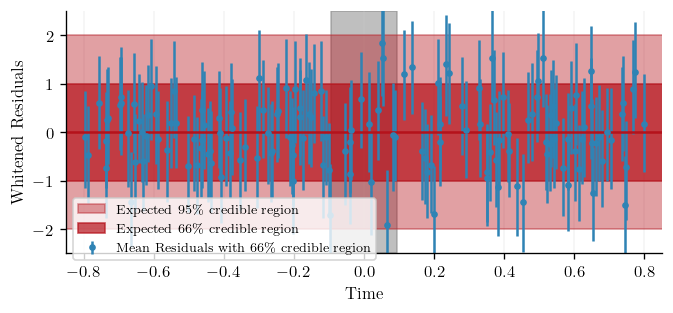

In [15]:
fig, ax = plt.subplots()

plt.errorbar(
    t_train,
    white_res_percentiles[0],
    [
        white_res_percentiles[0] - white_res_percentiles[1],
        white_res_percentiles[2] - white_res_percentiles[0],
    ],
    fmt=".",
    label=r"Mean Residuals with 66\% credible region",
)

plt.axhline()
ax.fill_between(
    [-1, 1],
    -2,
    2,
    alpha=0.4,
    label=r"Expected 95\% credible region",
    color=cols[1],
)


ax.fill_between(
    [-1, 1],
    -1,
    1,
    alpha=0.7,
    label=r"Expected 66\% credible region",
    color=cols[1],
)


ax.fill_between(
    t,
    -2.5,
    2.5,
    where=~mask,
    alpha=0.5,
    color="grey",
    zorder=0,
)

ax.set_xlim([-0.85, 0.85])
ax.set_ylim([-2.5, 2.5])
ax.legend(loc="center left", bbox_to_anchor=(0, 0.1))
ax.set_ylabel("Whitened Residuals")
ax.set_xlabel("Time")
plt.savefig("figures/residuals_ar.pdf")

In [16]:
arr = whited_res_samples.T


def bin_and_average(arr, bin_size):
    # Calculate the number of bins
    num_bins = len(arr) // bin_size

    # Reshape the array to (num_bins, bin_size, array_width)
    reshaped_arr = arr[: num_bins * bin_size].reshape(num_bins, bin_size, arr.shape[1])

    # Compute the mean along the bin_size axis
    binned_mean = reshaped_arr.mean(axis=1)

    std = binned_mean.std(axis=0)

    vals = np.percentile(std, [50, 16, 84, 2.5, 95])

    return vals


std_percentiles = []
bin_sizes = range(1, len(arr) // 2 + 1)

# Iterate from bin size 1 to half the length of the array
for bin_size in bin_sizes:
    std_percentiles.append(bin_and_average(arr, bin_size))

vals = np.array(std_percentiles)

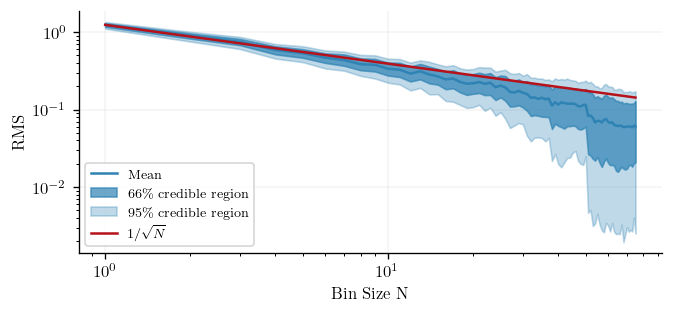

In [17]:
plt.loglog(bin_sizes, vals[:, 0], color=cols[0], label="Mean")
plt.fill_between(
    bin_sizes,
    vals[:, 1],
    vals[:, 2],
    alpha=0.7,
    color=cols[0],
    label=r"66\% credible region",
)
plt.fill_between(
    bin_sizes,
    vals[:, 3],
    vals[:, 4],
    alpha=0.3,
    color=cols[0],
    label=r"95\% credible region",
)

k = [vals[0, 0] / np.sqrt(N) for N in bin_sizes]
plt.plot(bin_sizes, k, color=cols[1], label=r"$1/\sqrt{N}$")

plt.legend(loc="center left", bbox_to_anchor=(0, 0.2))
plt.ylabel("RMS")
plt.xlabel("Bin Size N")

plt.savefig("figures/allandev_ar.pdf")